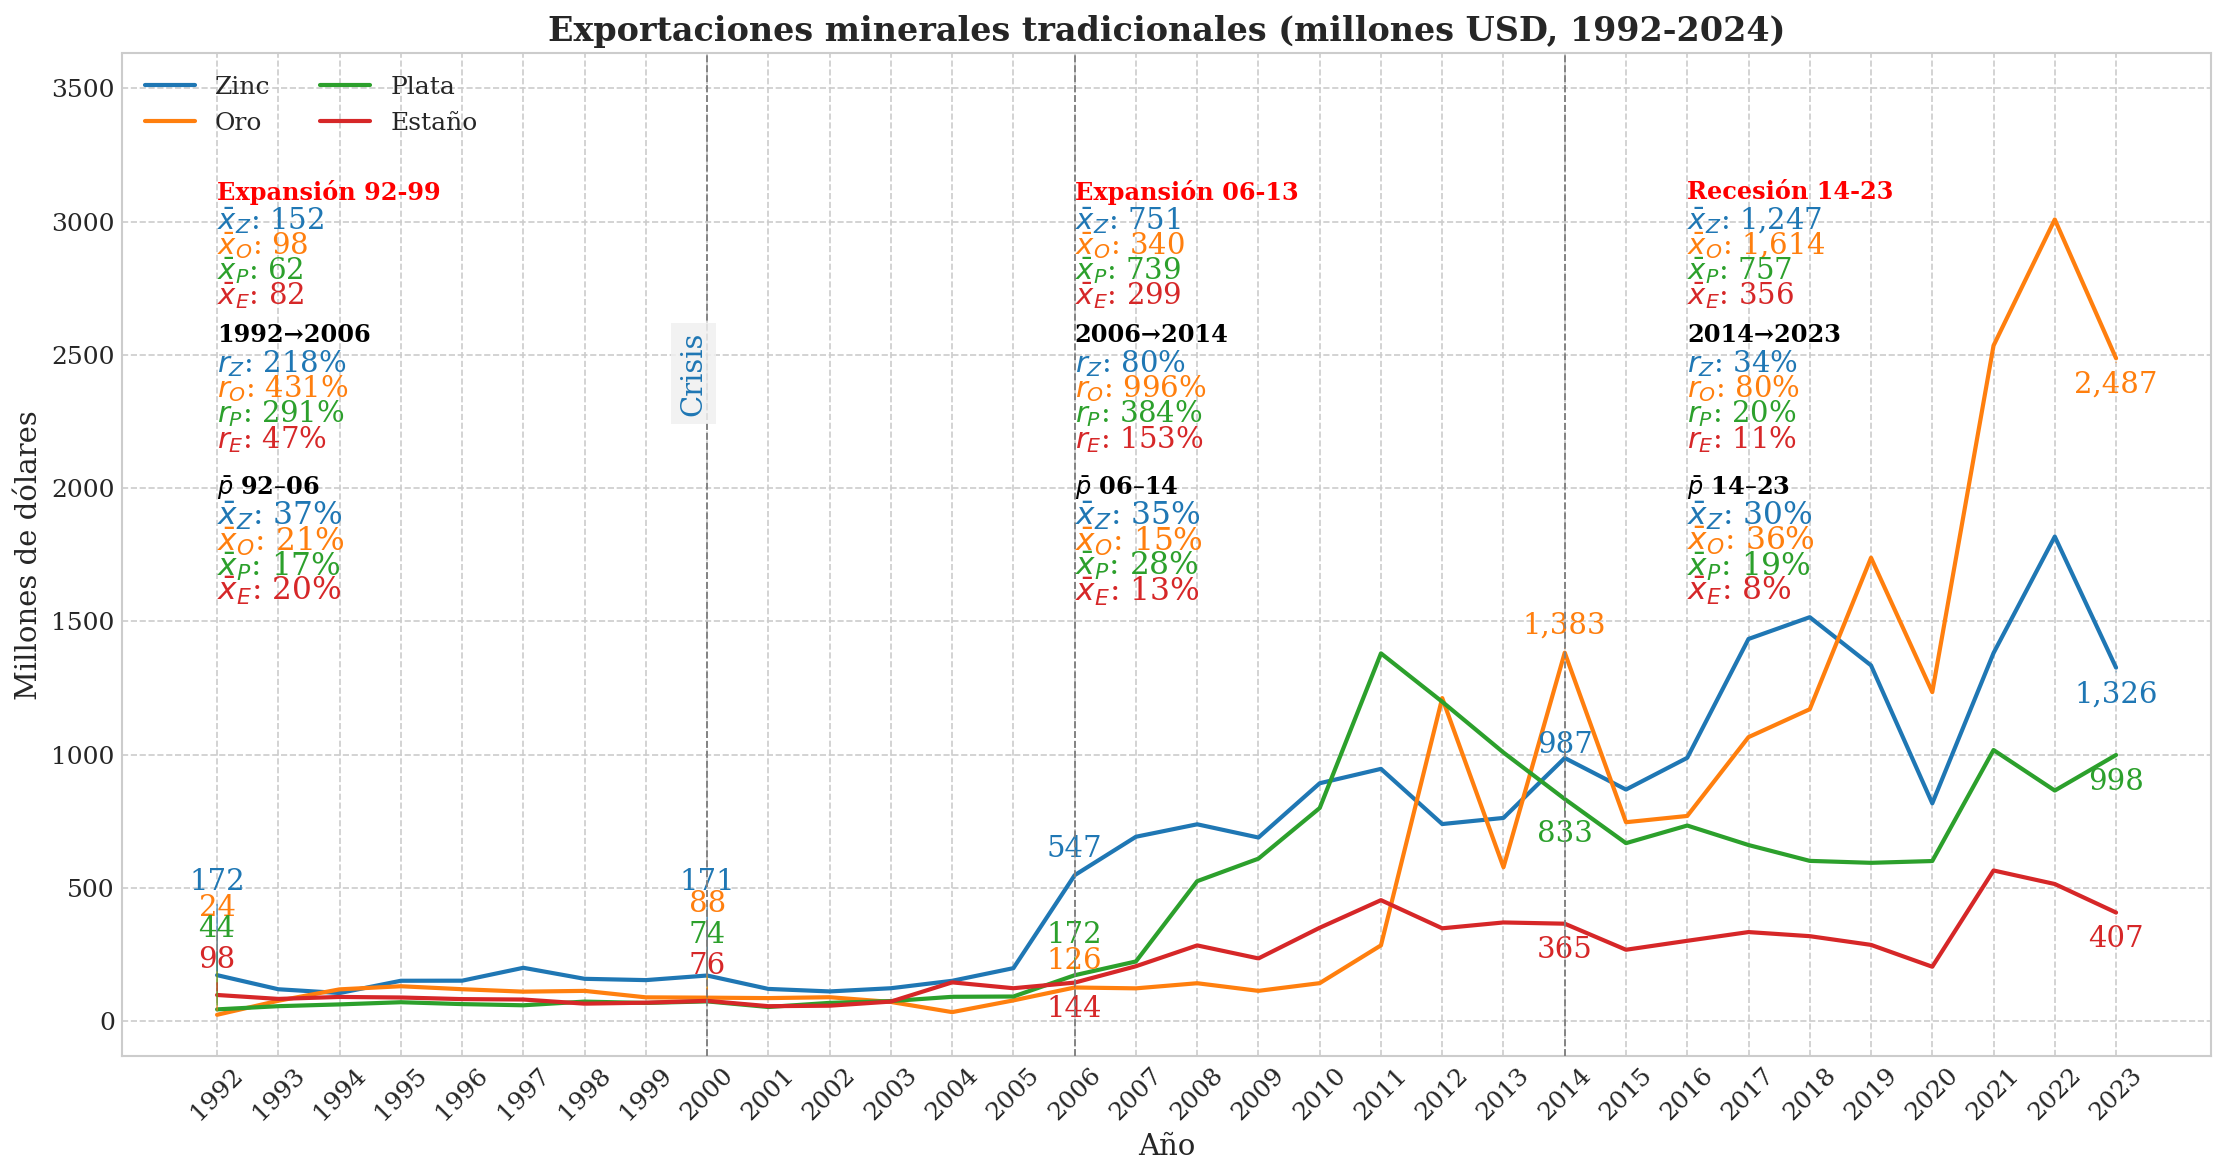

In [1]:
# ───────────────────────────── IMPORTS ──────────────────────────────
import sys, os, sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))          # utilidades propias
from graficos_utils import (
    add_hitos, add_cycle_means_multi,
    add_year_value_annotations, add_period_growth_annotations_multi,
    add_participation_cycle_boxes
)

# ── 0.  Tramos de ciclo ─────────────────────────────────────────────
EXPANSION_92_99   = slice(1992, 1999)
CRISIS_00_05      = slice(2000, 2005)
ACUMULACION_06_13 = slice(2006, 2013)
RECESION_14_23    = slice(2014, 2023)

periods = {
    "Expansión 92-99": EXPANSION_92_99,
    "Expansión 06-13": ACUMULACION_06_13,
    "Recesión 14-23":  RECESION_14_23,
}

# ── 1. Configuración general ───────────────────────────────────────
output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 12,
    'axes.titlesize': 16,   'axes.labelsize': 14,
    'grid.linestyle': '--', 'lines.linewidth': 2,
    'figure.dpi': 150,      'savefig.bbox': 'tight'
})

# ── 2. Carga de datos ──────────────────────────────────────────────
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql(
                   "SELECT * FROM exportaciones_minerales_totales WHERE año > 1991",
                   conn)
                 .set_index('año')
                 .sort_index())

# Cols de valor (miles USD) → millones USD
valor_cols = [c for c in df.columns if c.endswith('_valor')]
df[valor_cols] = df[valor_cols] / 1000            # ⇢ millones USD
df['total'] = df[valor_cols].sum(axis=1)
# ── 3. Estadísticas por ciclo ───────────────────────────────────────
component_cols = ['zinc_valor','oro_valor','plata_valor','estaño_valor']
cycle_stats = {
    name: df.loc[period, component_cols].mean().to_dict()
    for name, period in periods.items()
}

# ── 4. Offsets y utilidades ─────────────────────────────────────────
hitos_v      = {1982:"Crisis", 1986:"Expansión", 2000:"Crisis",
                2006:"Expansión", 2014:"Recesión"}
hitos_offset = {a:0.82 for a in hitos_v}

medias_offset = {
    "Expansión 92-99": (1992, 1),
    "Expansión 06-13": (2006, 1),
    "Recesión 14-23":  (2016, 1),
}

anot_years = [1992, 2000, 2006, 2014, 2023]  # ajusta a tu gusto
annotation_offsets = {
    'zinc_valor': {1992: (0, 350), 2000: (0, 350), 2006: (0, 100), 2014: (0, 50), 2023: (0, -100)},
    'oro_valor':  {1992: (0, 400), 2000: (0, 350), 2006: (0, 100), 2014: (0, 100), 2023: (0, -100)},
    'plata_valor': {1992: (0, 300), 2000: (0, 250), 2006: (0, 150), 2014: (0, -130), 2023: (0, -100)},
    'estaño_valor': {1992: (0, 130), 2000: (0, 130), 2006: (0, -100), 2014: (0, -100), 2023: (0, -100)}
}

annotation_tasas_offsets = {
    "1992-2006": (1992, 0.83), 
    "2006-2014": (2006, 0.83),
    "2014-2023": (2016, 0.83),
}
participation_offsets = {
    "1992-2006": (1992, 0.65),
    "2006-2014": (2006, 0.65),
    "2014-2023": (2016, 0.65),
}

# ── 5. Gráfico ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))

color_map = {
    'zinc_valor'  : '#1f77b4',
    'oro_valor'   : '#ff7f0e',
    'plata_valor' : '#2ca02c',
    'estaño_valor': '#d62728',
}
labels_map = {
    'zinc_valor'  : 'Zinc',
    'oro_valor'   : 'Oro',
    'plata_valor' : 'Plata',
    'estaño_valor': 'Estaño',
}

for col in component_cols:
    ax.plot(df.index, df[col], label=labels_map[col], color=color_map[col])

# ── 6. Hitos y anotaciones ─────────────────────────────────────────
add_hitos(ax, df.index, hitos_v, hitos_offset, line_kwargs={'linewidth':0.9})

abbr_map = {c: labels_map[c][0] for c in component_cols}
line_spacing = ax.get_ylim()[1] * 0.03
add_cycle_means_multi(ax, cycle_stats, medias_offset,
                      abbr_map, color_map, line_spacing)

add_year_value_annotations(ax, df, anot_years,
                           component_cols, annotation_offsets,
                           color_map, arrow_lw=0.5)

df_g = df.replace(0, np.nan)
periodos = [(1992, 2006), (2006, 2014), (2014, 2023)]
add_period_growth_annotations_multi(ax, df_g, periodos,
    component_cols, annotation_tasas_offsets, color_map, abbr_map)

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    component_cols,           # componentes
    'total',              # total de exportaciones tradicionales
    participation_offsets,
    abbr_map=abbr_map,
    colors=color_map
)

# ── 7. Ajustes finales ──────────────────────────────────────────────
ax.set_title("Exportaciones minerales tradicionales (millones USD, 1992-2024)",
             fontweight='bold')
ax.set_xlabel("Año")
ax.set_ylabel("Millones de dólares")
ax.set_xticks(df.index[::max(1, len(df)//30)])
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', fontsize=12, ncol=2)

y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min*1.05, y_max*1.15)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "exportaciones_minerales_valores.png"))
plt.show()
